In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC 

# ==============================================================================
# 1. CARREGAMENTO E PREPARAÇÃO DOS DADOS
# ==============================================================================
train = pd.read_csv("../data/training.csv")
test = pd.read_csv("../data/testing.csv")

# Separação entre Features (Matriz X) e Target (Vetor y)
# Nota: O SVM matemático exige rótulos numéricos, mas o sklearn converte
# strings/classes automaticamente internamente.
X_train = train.drop(columns=["Class"])
y_train = train["Class"]

X_test = test.drop(columns=["Class"])
y_test = test["Class"]

# ==============================================================================
# 2. PRÉ-PROCESSAMENTO (ESCALONAMENTO)
# ==============================================================================
# CRÍTICO PARA SVM: O algoritmo SMO e o Kernel RBF são baseados em distâncias.
# O Kernel RBF calcula exp(-gamma * ||x - y||^2). Se uma variável tiver escala
# muito maior (ex: Salário vs Idade), ela dominará o cálculo da distância Euclidiana,
# impedindo o SVM de aprender corretamente com as outras features.
#
# O StandardScaler aplica a normalização Z-score: z = (x - u) / s
# Média (u) torna-se 0 e desvio padrão (s) torna-se 1.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Aprende média/desvio no treino
X_test_scaled = scaler.transform(X_test)       # Aplica a mesma transformação no teste

# ==============================================================================
# 3. CONFIGURAÇÃO DO MODELO (SVC - Support Vector Classification)
# ==============================================================================
# O SVC do sklearn é um wrapper para a biblioteca "LibSVM" (escrita em C++).
# Ela implementa o algoritmo SMO (Sequential Minimal Optimization) para resolver
# o problema de Otimização Quadrática (QP) na Forma Dual.

svm = SVC(
    # kernel='rbf': Radial Basis Function (Gaussiano).
    # Realiza o "Kernel Trick", mapeando os dados para dimensão infinita sem custo computacional.
    # K(x, x') = exp(-gamma * ||x - x'||^2)
    kernel='rbf', 
    
    # C (Regularization Parameter): Controla a "Box Constraint" no problema Dual.
    # Restrição teórica: 0 <= alpha_i <= C
    # C Alto: Tenta classificar tudo corretamente (Risco de Overfitting / Margem estreita).
    # C Baixo: Aceita erros na margem para ter uma fronteira mais suave (Regularização forte).
    C=1.0, 
    
    # gamma: Coeficiente do Kernel RBF. Define o "alcance" de um único exemplo de treino.
    # 'scale' é a heurística recomendada: 1 / (n_features * X.var())
    # Gamma Alto: O alcance é curto, gera "ilhas" de decisão (Overfitting).
    # Gamma Baixo: O alcance é longo, gera fronteiras quase lineares (Underfitting).
    gamma='scale', 
    
    random_state=42
)

# ==============================================================================
# 4. TREINAMENTO (RESOLVENDO O PROBLEMA DUAL)
# ==============================================================================
print("Treinando SVM (Otimização SMO via LibSVM)...")
# Aqui o algoritmo encontra os Multiplicadores de Lagrange (alphas) ótimos.
# Ele busca maximizar a margem respeitando as restrições y_i * (w*x + b) >= 1 - slack.
svm.fit(X_train_scaled, y_train)

# ==============================================================================
# 5. PREDIÇÃO E AVALIAÇÃO
# ==============================================================================
print("Fazendo predições...")
# A predição usa apenas os Vetores de Suporte (onde alpha > 0).
# Fórmula: y_pred = sign( somatorio(alpha_i * y_i * K(x_i, x_novo)) + b )
# Pontos com alpha = 0 são ignorados, o que torna a predição eficiente.
y_pred = svm.predict(X_test_scaled)

acuracia = accuracy_score(y_test, y_pred)
print(f"Acurácia Final: {acuracia * 100:.2f}%")

# Análise dos Vetores de Suporte:
# Indica quantos pontos foram necessários para "segurar" a fronteira de decisão.
# Um número muito alto de vetores de suporte (perto do total de amostras)
# pode indicar que o modelo está "decorando" os dados (Overfitting).
print(f"Total de Vetores de Suporte Utilizados: {svm.n_support_.sum()}")

Treinando SVM (Otimização SMO via LibSVM)...
Fazendo predições...
Acurácia Final: 81.08%
Total de Vetores de Suporte Utilizados: 5862


In [3]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

# Vetores de suporte
SV = svm.support_vectors_

# Coeficientes dual (α_i y_i)
dual_coef = svm.dual_coef_[0]

# Kernel RBF entre vetores de suporte
K_sv = rbf_kernel(SV, SV, gamma=svm._gamma)

# Norma ao quadrado de w no espaço RKHS
w_norm_sq = dual_coef @ K_sv @ dual_coef.T

# Margem geométrica
margin = 2 / np.sqrt(w_norm_sq)

print(f"Margem no espaço de kernel (RBF): {margin:.6f}")


Margem no espaço de kernel (RBF): 0.038833


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay #as nossas métricas de avaliação
import matplotlib.pyplot as plt

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Fração de predições corretas (accuracy)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

print(f"\nOverall fraction of correct predictions: {accuracy:.4f}")


Confusion Matrix:
[[138  51]
 [ 47 282]]

Overall fraction of correct predictions: 0.8108


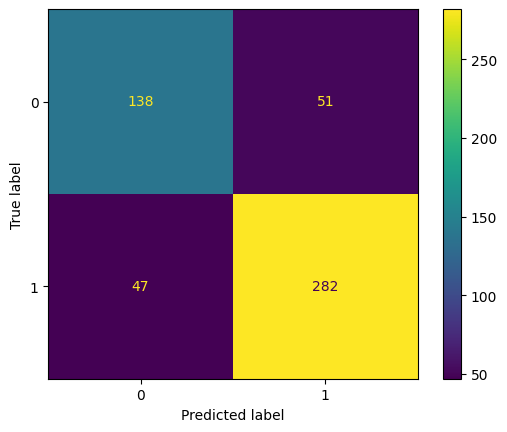

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()